---
## 2019313550 박병현 6th Assignment (Due:5/26, 23:59)

### Write your sequential modeling code to forecast the closing value of the KOSDAQ

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ^KQ11.csv to ^KQ11.csv


In [2]:
!ls -al
!pwd

total 436
drwxr-xr-x 1 root root   4096 Jun  7 02:25  .
drwxr-xr-x 1 root root   4096 Jun  7 02:21  ..
drwxr-xr-x 4 root root   4096 Jun  5 13:29  .config
-rw-r--r-- 1 root root 427591 Jun  7 02:25 '^KQ11.csv'
drwxr-xr-x 1 root root   4096 Jun  5 13:35  sample_data
/content


data length: 5832
The first 20 data:
 [[858.5      873.900024 851.299988 867.099976]
 [849.599976 860.099976 791.099976 804.      ]
 [788.5      811.400024 758.200012 802.599976]
 [793.599976 820.400024 786.900024 798.400024]
 [834.700012 840.900024 822.5      826.200012]
 [820.       829.799988 794.400024 796.400024]
 [793.599976 809.799988 784.799988 808.900024]
 [805.       816.200012 801.700012 808.599976]
 [793.799988 802.       785.400024 793.799988]
 [806.400024 810.099976 780.5      783.700012]
 [776.400024 779.799988 735.200012 741.799988]
 [719.299988 748.       676.900024 746.799988]
 [762.       771.099976 756.799988 763.599976]
 [758.       790.099976 755.700012 782.5     ]
 [800.700012 809.799988 788.200012 795.400024]
 [794.       816.900024 792.099976 804.599976]
 [803.900024 810.299988 790.599976 796.299988]
 [793.799988 804.5      784.200012 793.099976]
 [785.299988 801.099976 785.299988 801.099976]
 [800.5      810.900024 798.400024 808.299988]]


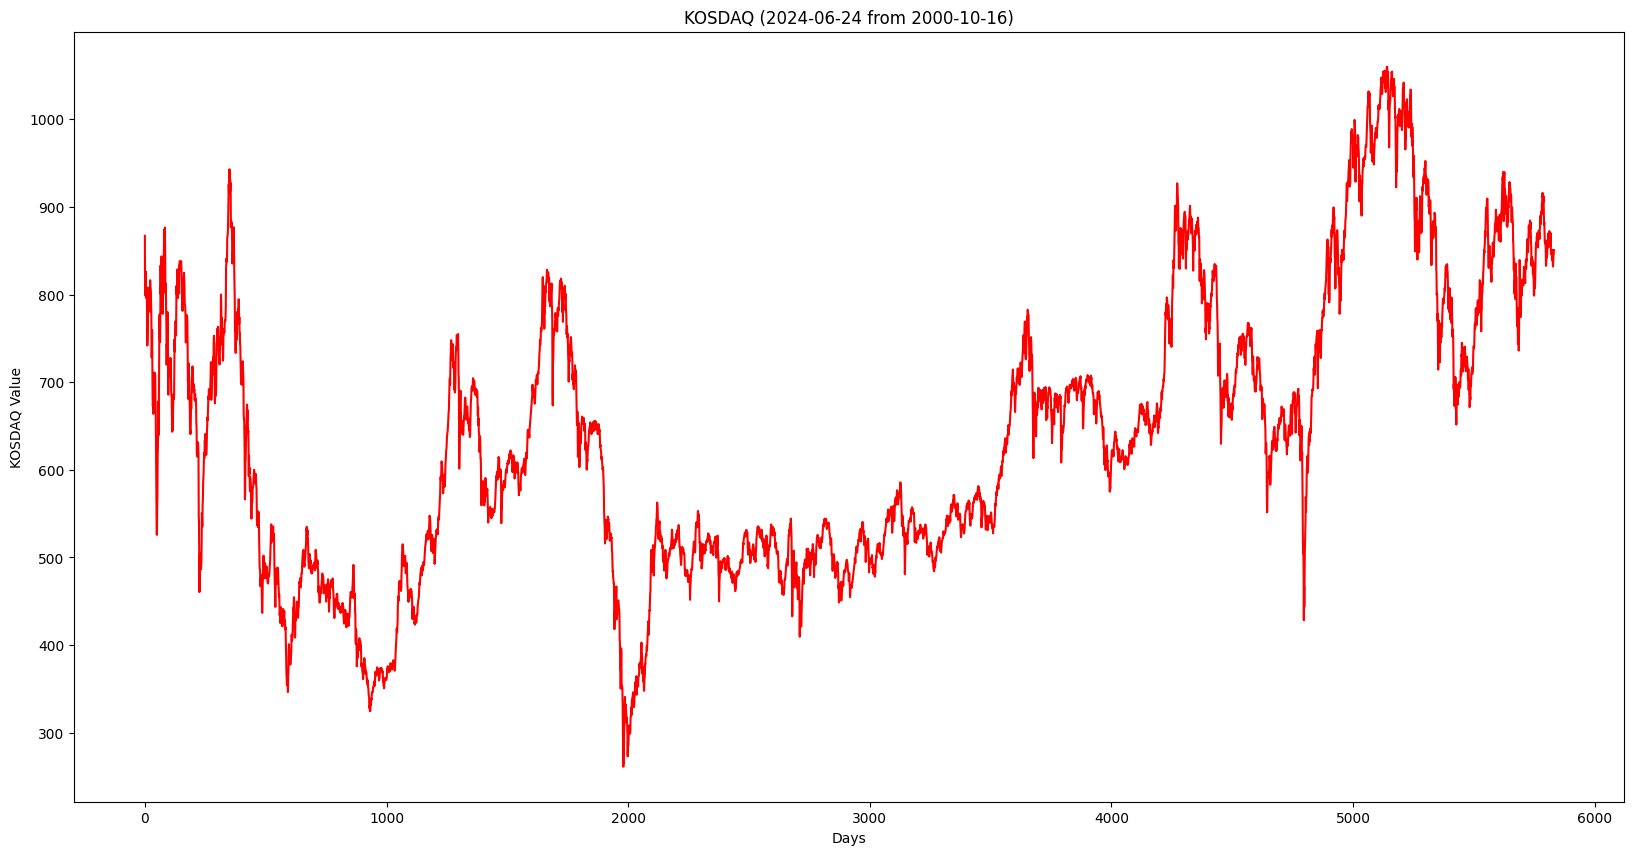

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

f = open('^KQ11.csv','r')
kosdaq_data = pd.read_csv(f,header=0)
kosdaq_data = kosdaq_data.dropna()     #drop all rows that have any NaN values
seq = kosdaq_data[['Open', 'High', 'Low', 'Close']].to_numpy()
data_length = len(seq)
print('data length:', data_length)
print('The first 20 data:\n', seq[:20])

# plotting
plt.figure(figsize=(20,10))
plt.plot(seq[:,3],color='red')
plt.title('KOSDAQ (2024-06-24 from 2000-10-16)')
plt.xlabel('Days')
plt.ylabel('KOSDAQ Value')
plt.show()

##2. Feaute Scaling

In [4]:
price = kosdaq_data[['Close']]
print(price.head())
print(price.shape)

        Close
0  867.099976
1  804.000000
2  802.599976
3  798.400024
4  826.200012
(5832, 1)


MinMaxScaler transform features by scaling each feature to a given range say -1 to 1.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
print(price.head())
print(price.shape)

      Close
0  0.517032
1  0.359047
2  0.355541
3  0.345026
4  0.414629
(5832, 1)


<ipython-input-5-5ff8cd89eafb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


### Split the Dataset
*   Prepare 80% for training
*   Prepare 20% for test

In [6]:
#split training and validation sets manually
dataset = price.values

test_set_size = int(np.round(0.2*price.shape[0]))
train_set_size = price.shape[0] - test_set_size
print(test_set_size)
print(train_set_size)

train = dataset[0:train_set_size,:]
print(train.shape)

test = dataset[train_set_size:,:]
print(test.shape)

1166
4666
(4666, 1)
(1166, 1)


### Creating Sliding Window
The sliding window is needed to accommodate the last 21 days close price values based on which RNN will predict the 22-nd day close price values.

Typically the intraday players go with 21/14/9 days EMI for VWAP/RSI calculations. Based out of this habit, we will be picking up high duration of 21 days for this model training.

In [7]:
# Split the dataset
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [8]:
lookback = 21 + 1
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4648, 21, 1)
y_train.shape =  (4648, 1)
x_test.shape =  (1162, 21, 1)
y_test.shape =  (1162, 1)


In [9]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

##2. Using LSTM for Predicting Stock Price

#### LSTM Model

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

* **batch_first** – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

In [10]:
input_dim = 1
hidden_dim = 16
num_layers = 3
output_dim = 1
num_epochs = 500

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #2
        out = self.fc(out[:, -1, :])
        return out

In [12]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#### Train Model

In [13]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.10074806213378906
Epoch  1 MSE:  0.10418117791414261
Epoch  2 MSE:  0.09767483174800873
Epoch  3 MSE:  0.09741107374429703
Epoch  4 MSE:  0.093633271753788
Epoch  5 MSE:  0.08474136888980865
Epoch  6 MSE:  0.0759841650724411
Epoch  7 MSE:  0.059494003653526306
Epoch  8 MSE:  0.02791873924434185
Epoch  9 MSE:  0.014028803445398808
Epoch  10 MSE:  0.03690623492002487
Epoch  11 MSE:  0.026069192215800285
Epoch  12 MSE:  0.02061648480594158
Epoch  13 MSE:  0.009761043824255466
Epoch  14 MSE:  0.011076124384999275
Epoch  15 MSE:  0.016729557886719704
Epoch  16 MSE:  0.018007393926382065
Epoch  17 MSE:  0.017027465626597404
Epoch  18 MSE:  0.01611793227493763
Epoch  19 MSE:  0.014405649155378342
Epoch  20 MSE:  0.010874333791434765
Epoch  21 MSE:  0.007963093928992748
Epoch  22 MSE:  0.008966933004558086
Epoch  23 MSE:  0.011097270995378494
Epoch  24 MSE:  0.010647637769579887
Epoch  25 MSE:  0.010096020065248013
Epoch  26 MSE:  0.009546296671032906
Epoch  27 MSE:  0.0073453

In [14]:
actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(actuals.head())
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(preds.head())

            0
0  800.900024
1  816.400085
2  808.599976
3  806.799988
4  801.700012
            0
0  779.137329
1  799.010437
2  816.354065
3  809.352905
4  805.463318


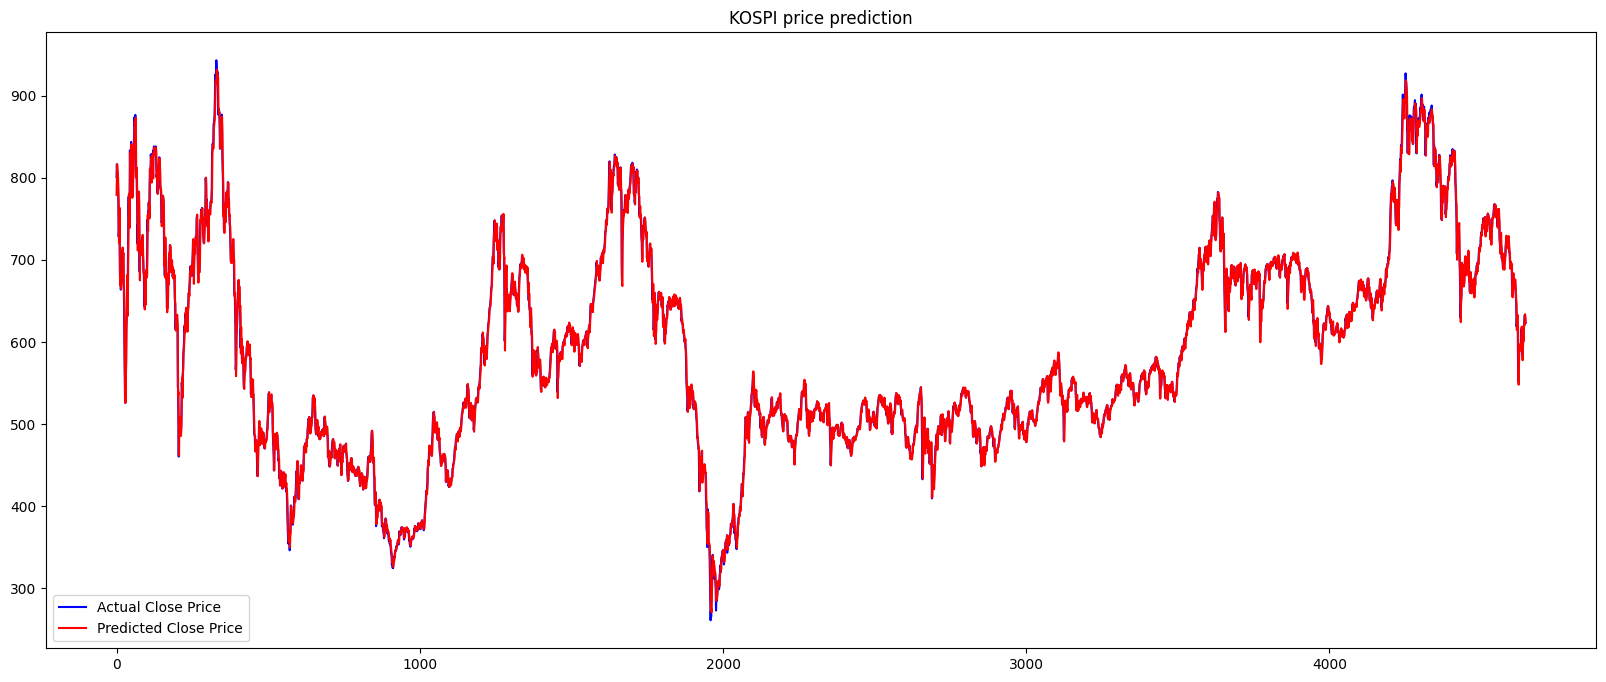

In [15]:
#Plot all predictions
train = price[0:len(actuals)]
valid = actuals

valid['Actuals'] = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid['Actuals'], color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('KOSPI price prediction')
plt.legend()
plt.show()

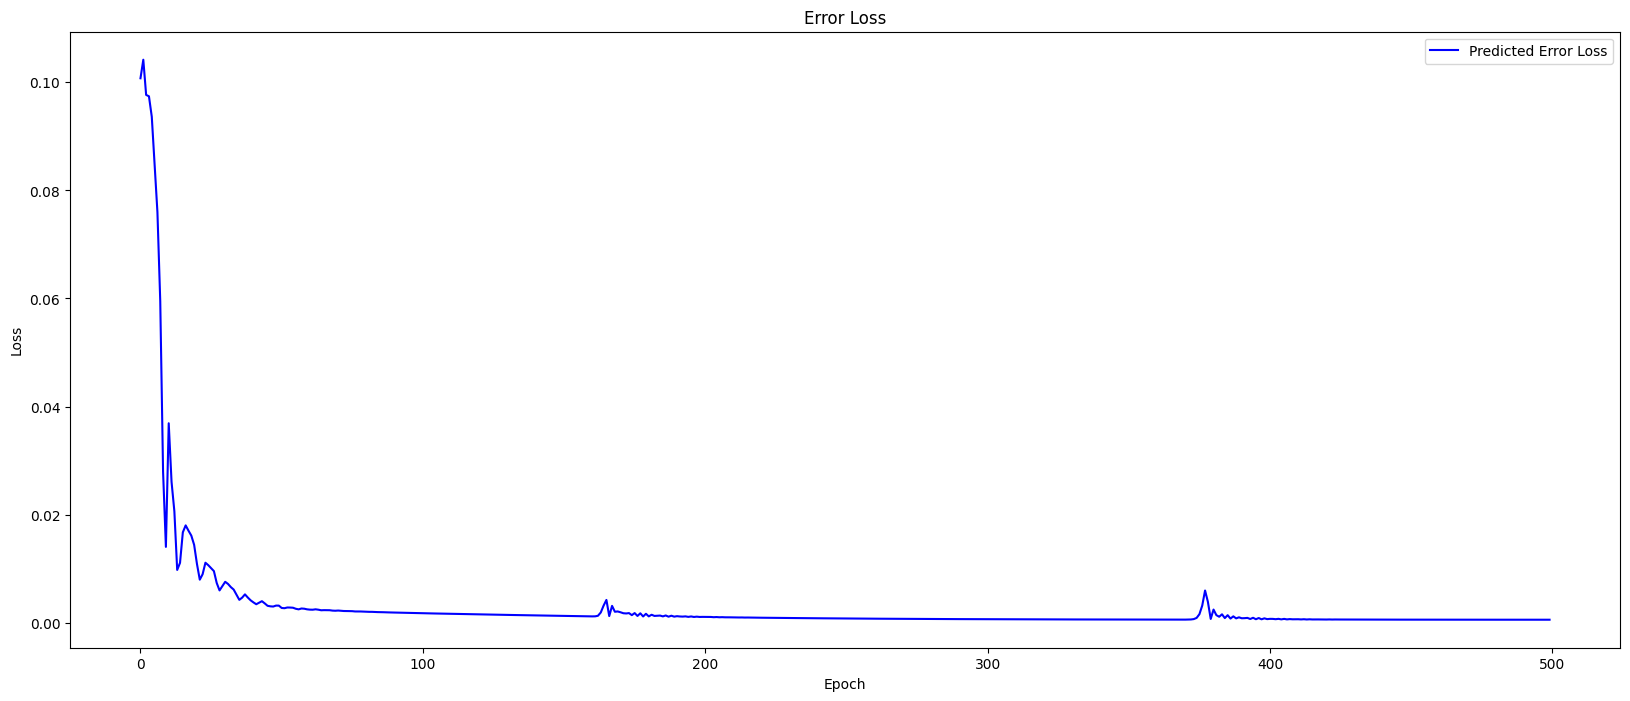

In [16]:
#Plot error loss
epochs = np.arange(num_epochs)
plt.figure(figsize=(20,8))
plt.plot(epochs, hist, color = 'blue', label = 'Predicted Error Loss')
plt.title('Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict on Test Data

In [17]:
print(x_test.shape)
print(y_test.shape)

torch.Size([1162, 21, 1])
(1162, 1)


In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_train_pred = model(x_train)
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

#### Calculate Root Mean Square Errors for Loss

In [19]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)

Train Score: 9.36 RMSE
Test Score: 13.66 RMSE


Actual Close Scalar
               0
4666  631.150024
4667  625.770020
4668  623.250000
4669  630.369995
4670  638.590027
Predicted Close Scalar
            0
0  622.271057
1  631.753845
2  641.077637
3  646.044922
4  645.277832


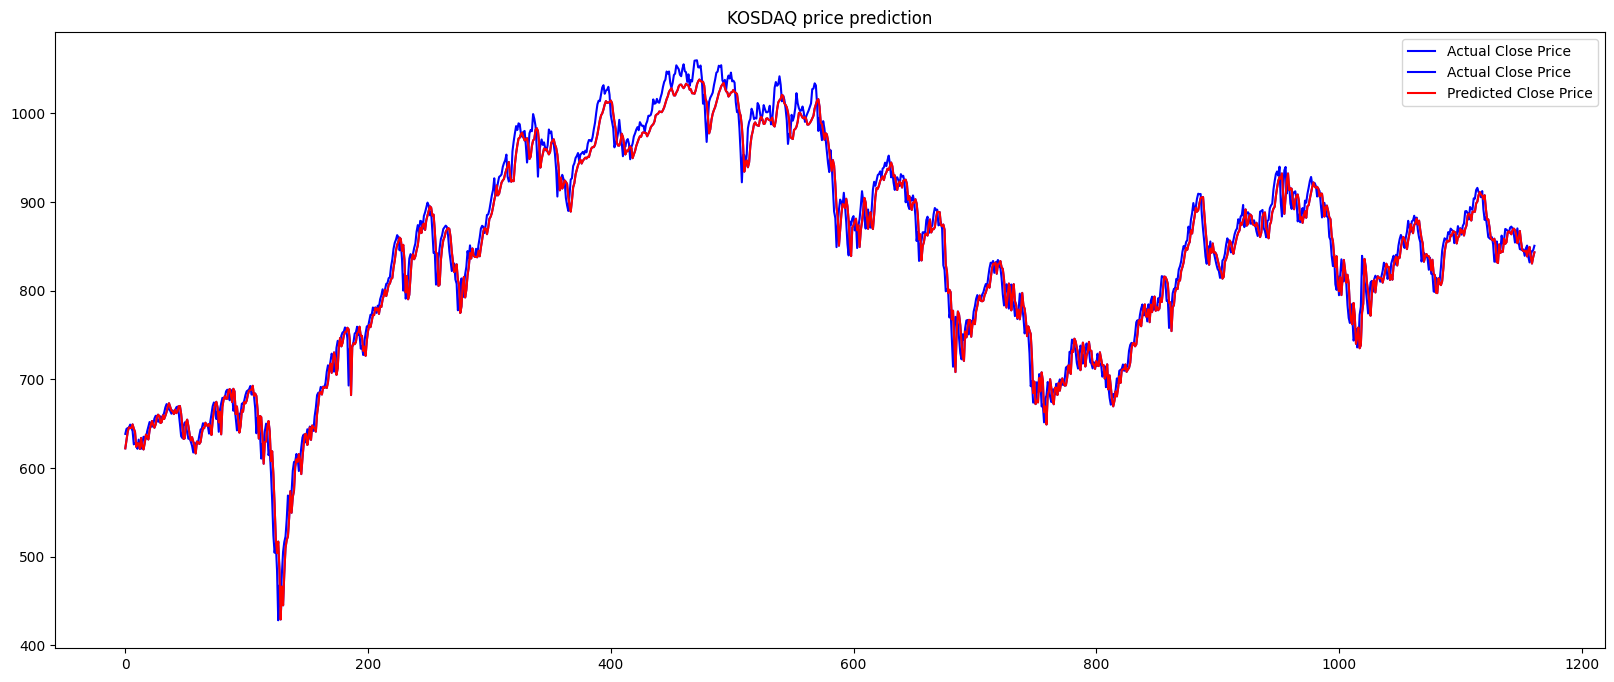

In [20]:
#Shift test predictions for plotting
original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
print("Actual Close Scalar")
print(actuals[train_set_size:].head())
preds = pd.DataFrame(y_test_pred)
print("Predicted Close Scalar")
print(preds.head())

#Prepare actual close entries
aScalar = actuals[len(price) - len(preds):len(price)]

#Reset indexes for actuals for last 1037 entries
aScalar = aScalar.reset_index(drop=True)

#Plot predictions/actuals close price for test entries
valid = aScalar
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('KOSDAQ price prediction')
plt.legend()
plt.show()

In [21]:
save_model = "predict_stock_price_using_lstm_in_pytorch"
torch.save(model.state_dict(), save_model)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0309],
         [ 0.5468],
         [-0.3655],
         [-0.0568],
         [ 0.2088],
         [ 0.3069],
         [-0.2995],
         [-0.2802],
         [-0.1918],
         [ 0.0928],
         [ 0.3692],
         [-0.1129],
         [-0.3544],
         [-0.0504],
         [-0.2998],
         [ 0.2074],
         [ 0.0037],
         [ 0.1456],
         [-0.2289],
         [-0.3819],
         [ 0.2642],
         [ 0.3831],
         [-0.2330],
         [-0.0915],
         [-0.1640],
         [ 0.5223],
         [ 0.0347],
         [-0.1293],
         [-0.2945],
         [ 0.8167],
         [-0.4126],
         [ 0.5160],
         [-0.3275],
         [ 0.5663],
         [-0.3041],
         [ 0.1570],
         [-0.3822],
         [-0.2625],
         [ 0.3492],
         [ 0.4208],
         [-0.2572],
         [ 0.6343],
         [-0.2599],
         [-0.3541],
         [ 0.2646],
         [-0.5804],
         [-0.0175],
         [ 0.3609],
         [-0.2342

### Predict from saved Model

- Lets hope to predict a new stock price based out of the saved model above.

- To load the model with all state parameters, we may use `torch.load()` method.

In [22]:
saved_model = "predict_stock_price_using_lstm_in_pytorch"
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model2.load_state_dict(torch.load(saved_model))
model2.eval()
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0309],
         [ 0.5468],
         [-0.3655],
         [-0.0568],
         [ 0.2088],
         [ 0.3069],
         [-0.2995],
         [-0.2802],
         [-0.1918],
         [ 0.0928],
         [ 0.3692],
         [-0.1129],
         [-0.3544],
         [-0.0504],
         [-0.2998],
         [ 0.2074],
         [ 0.0037],
         [ 0.1456],
         [-0.2289],
         [-0.3819],
         [ 0.2642],
         [ 0.3831],
         [-0.2330],
         [-0.0915],
         [-0.1640],
         [ 0.5223],
         [ 0.0347],
         [-0.1293],
         [-0.2945],
         [ 0.8167],
         [-0.4126],
         [ 0.5160],
         [-0.3275],
         [ 0.5663],
         [-0.3041],
         [ 0.1570],
         [-0.3822],
         [-0.2625],
         [ 0.3492],
         [ 0.4208],
         [-0.2572],
         [ 0.6343],
         [-0.2599],
         [-0.3541],
         [ 0.2646],
         [-0.5804],
         [-0.0175],
         [ 0.3609],
         [-0.2342